In [1]:
from tqdm import tqdm
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
np.set_printoptions(threshold=20)
#atts,sz = bns.attractors_from_txt('att_reach_simp')
#rsnodes = list(np.load('nodes_reach_simp.npy',allow_pickle=True))

In [103]:
r_params = [0,0.2,0.4,0.6,0.8,1]
oords = ['asc','desc']
att_d = {}
att_sizes_d = {}
#num_unchanged = []
#unchanged = []
for rep in tqdm(range(10)):
    for rr in r_params:
        if (rr ==0 or rr==1) and rep>0:
            continue
        for oord in oords:
            with open('attfiles/att_newneg2_rs2_%.2f_%s_%02d_1.txt' %(rr,oord,rep),encoding='utf-8') as fo:
                lines=fo.readlines()
            for i,line in enumerate(lines):
                if line.startswith('Attractor number:'):
                    #att_sizes.append(line.split(':')[-1].strip())
                    att_no = int(line.split(':')[1].split(' ')[0])
                    att_size = int(line.split(':')[-1].strip())
                    att_sizes_d[(oord,rr,rep,att_no)]=att_size
                    if att_size != 1:
                        att = []
                        for k in range(1,att_size+1):
                            state = lines[i-k].strip()
                            att.append(state)
                        att_str = ' '.join(att)
                        att_d[(oord,rr,rep,att_no)]=att_str
                        #sub = np.array([att[x,:]-att[x+1,:] for x in np.arange(-1,att_size-1,1)])
                        #u=np.where(~sub.any(axis=0))[0]
                        #unchanged.append(u)
                        #num_unchanged.append(len(u))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.96it/s]


In [20]:
att_sizes_ser = pd.Series(att_sizes_d)

/var/folders/cr/tmh4xbn13gv37d49tyk2lyx80000gn/T/ipykernel_27576/4177738930.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1,figsize=(1.683,.25*(my_arr.shape[0]+1)))


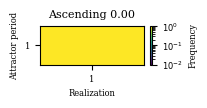

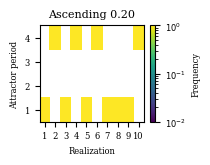

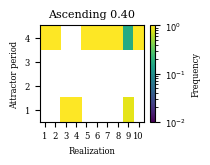

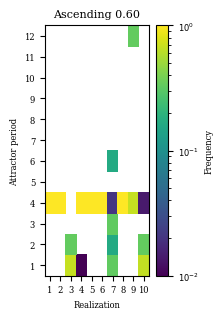

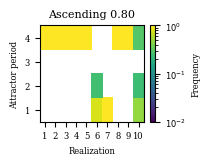

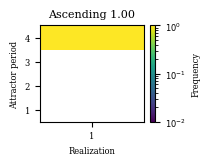

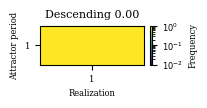

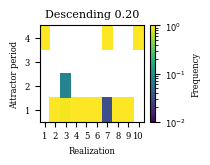

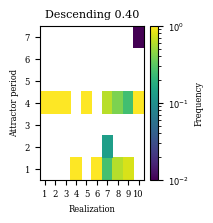

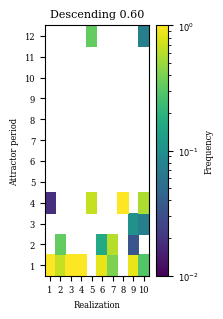

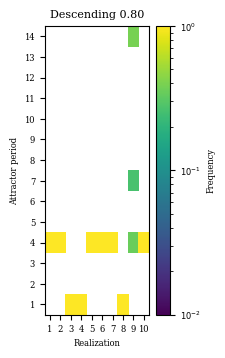

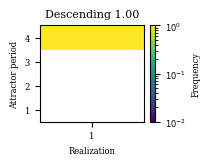

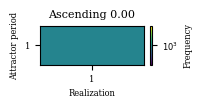

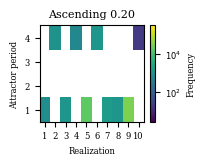

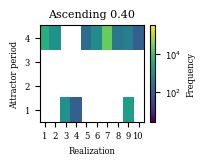

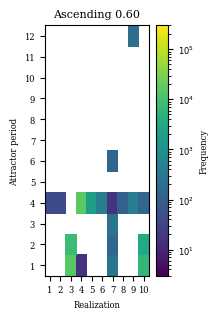

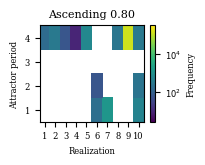

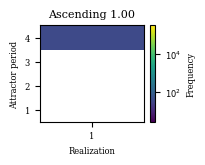

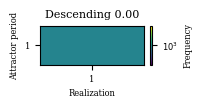

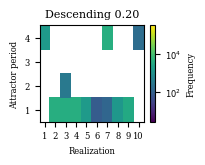

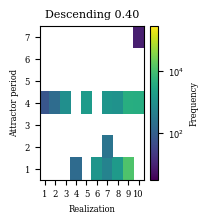

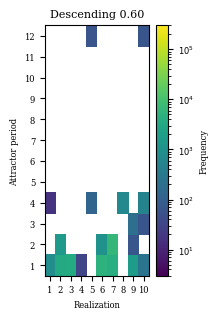

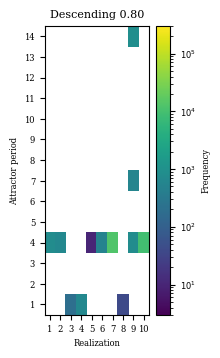

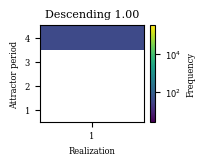

In [166]:
GB = att_sizes_ser.groupby(level=[0,1])
for isFreq in [True,False]:
    if isFreq:
        pref='asf'
        myNorm = LogNorm(vmin=1e-2, vmax=1)
    else:
        pref='asn'
        myNorm = LogNorm(vmin=3, vmax=3e5)
    for (order,rr),grp1 in GB:
        grp1.index = grp1.index.droplevel([0,1])
        rep_vcs_d = {}
        for rep,grp2 in grp1.groupby(level=0):
            rep_vcs_d[rep] = grp2.value_counts(normalize=isFreq)
        
        mydf = pd.DataFrame(rep_vcs_d).fillna(0)
        vmax = pd.DataFrame(rep_vcs_d).index.max()
        my_arr = np.zeros((vmax,mydf.shape[1]))
        for ii,row in mydf.iterrows():
            for jj,ff in row.items():
                my_arr[ii-1,jj]=ff
        fig,ax = plt.subplots(1,1,figsize=(1.683,.25*(my_arr.shape[0]+1)))
        tmp = ax.pcolor(my_arr,norm=myNorm)
        cb = fig.colorbar(tmp)
        cb.set_label('Frequency',size=6,family='Serif')
        plt.setp(cb.ax.yaxis.get_ticklabels(),size=6)
        ax.set_xticks(np.arange(my_arr.shape[1])+0.5)
        ax.set_yticks(np.arange(my_arr.shape[0])+0.5)
        TXT = 'Ascending' if order=='asc' else 'Descending'
        ax.set_title('%s %.2f' % (TXT,rr),size=8,family='Serif')
        ax.set_xticklabels(['%d' % (ii+1) for ii in range(my_arr.shape[1])],size=6,family='Serif')
        ax.set_yticklabels(['%d' % (ii+1) for ii in range(my_arr.shape[0])],size=6,family='Serif')
        ax.set_xlabel('Realization',size=6,family='Serif')
        ax.set_ylabel('Attractor period',size=6,family='Serif')
        fig.savefig('figs/%s_%s_%.2f.svg' % (pref,order,rr))
        plt.close()

In [235]:
#att_ser = pd.Series(att_d)
def get_attr_stats(anum,sattr,attrsize):
    sattr1 = np.asarray([[int(elt) for elt in bstr] for bstr in sattr.split(' ')])
    HH = [np.sum(np.abs(sattr1[(jj+1)%attrsize]-sattr1[jj])) for jj in range(attrsize)]
    ss = np.sum(sattr1,axis=0)
    cnodes = np.where((ss>0)&(ss<4))[0]
    return anum,cnodes,HH
hamming_steps2 = {}
changing_nodes2 = {}
changing_node_sets2 = {}
for order in ['asc','desc']:
    print(order)
    for rr in [0.2,0.4,0.6,0.8]:
        print('--->',rr)
        for xx in range(10):
            print('------->',xx)
            sel_attrs = att_ser.xs((order,rr,xx),level=[0,1,2])
            for anum,sattr in sel_attrs.items():
                attrsize = len(sattr.split(' '))
                anum,cnds,HH = get_attr_stats(anum,sattr,attrsize)
                hamming_steps2[(order,rr,xx,anum)]=HH
                changing_nodes2[(order,rr,xx,anum)]=cnds

for ii,nd_l in changing_nodes2.items():
    changing_node_sets2[ii]=' '.join(['%d' % nd for nd in nd_l])


asc
---> 0.2
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
---> 0.4
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
---> 0.6
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
---> 0.8
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
desc
---> 0.2
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
---> 0.4
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
---> 0.6
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9
---> 0.8
-------> 0
-------> 1
-------> 2
-------> 3
-------> 4
-------> 5
-------> 6
-------> 7
-------> 8
-------> 9


In [239]:
myS = set([])
for kk in hamming_steps2.keys():
    S = set([tuple(kk[:-1])])
    myS |= S
len(myS)

58

In [241]:
sel_keys = [k for k in hamming_steps2.keys() if tuple(k[:-1])==('asc', 0.2, 1)]
len(sel_keys)

1064

0  1  2  3
asc 0.2 1 1     7  5  6  4
          2     7  5  6  4
          3     6  4  7  5
          4     4  7  5  6
          5     3  7  3  7
...            .. .. .. ..
          1060  3  7  3  7
          1061  3  7  3  7
          1062  3  7  3  7
          1063  3  7  3  7
          1064  3  7  3  7

[1064 rows x 4 columns]

In [240]:
myS

{('asc', 0.2, 1),
 ('asc', 0.2, 3),
 ('asc', 0.2, 5),
 ('asc', 0.2, 9),
 ('asc', 0.4, 0),
 ('asc', 0.4, 1),
 ('asc', 0.4, 4),
 ('asc', 0.4, 5),
 ('asc', 0.4, 6),
 ('asc', 0.4, 7),
 ('asc', 0.4, 8),
 ('asc', 0.4, 9),
 ('asc', 0.6, 0),
 ('asc', 0.6, 1),
 ('asc', 0.6, 2),
 ('asc', 0.6, 3),
 ('asc', 0.6, 4),
 ('asc', 0.6, 5),
 ('asc', 0.6, 6),
 ('asc', 0.6, 7),
 ('asc', 0.6, 8),
 ('asc', 0.6, 9),
 ('asc', 0.8, 0),
 ('asc', 0.8, 1),
 ('asc', 0.8, 2),
 ('asc', 0.8, 3),
 ('asc', 0.8, 4),
 ('asc', 0.8, 5),
 ('asc', 0.8, 7),
 ('asc', 0.8, 8),
 ('asc', 0.8, 9),
 ('desc', 0.2, 0),
 ('desc', 0.2, 2),
 ('desc', 0.2, 6),
 ('desc', 0.2, 9),
 ('desc', 0.4, 0),
 ('desc', 0.4, 1),
 ('desc', 0.4, 2),
 ('desc', 0.4, 4),
 ('desc', 0.4, 6),
 ('desc', 0.4, 7),
 ('desc', 0.4, 8),
 ('desc', 0.4, 9),
 ('desc', 0.6, 0),
 ('desc', 0.6, 1),
 ('desc', 0.6, 4),
 ('desc', 0.6, 5),
 ('desc', 0.6, 6),
 ('desc', 0.6, 7),
 ('desc', 0.6, 8),
 ('desc', 0.6, 9),
 ('desc', 0.8, 0),
 ('desc', 0.8, 1),
 ('desc', 0.8, 4),
 ('de

In [155]:
ii=3
ndset = [3, 6, 24, 40, 55, 57, 67, 73, 74, 75, 85]
for xxx in [''.join([elt for jj,elt in enumerate(bstr) if jj in ndset]) for bstr in sel_attrs.loc[ii].split(' ')]:
    print(xxx)

01111010110
00001101110
10000100001
11110110011


In [212]:
pd.DataFrame(hamming_steps)

,1,2,5,6,12,13,14,15,16,17,...,4215,4216,4217,4218,4219,4220,4221,4222,4223,4224
0,4,3,6,3,7,7,7,4,4,4,...,1,6,6,6,6,1,1,1,1,1
1,1,6,3,7,5,4,5,7,7,7,...,4,3,3,3,3,4,4,4,4,4
2,4,3,7,4,8,6,8,5,5,5,...,1,6,6,6,6,1,1,1,1,1
3,1,6,4,6,4,3,4,8,8,8,...,4,3,3,3,3,4,4,4,4,4


In [ ]:
a & (b & (c | d))
abc | abd

In [ ]:
B(x_{a=a_1})=B_1
B(x_{a=\bar{a}_1, b=b_1})=B_2

In [213]:
changing_node_sets = {}
for ii,nd_l in changing_nodes.items():
    changing_node_sets[ii]=' '.join(['%d' % nd for nd in nd_l])
pd.Series(changing_node_sets).value_counts()

0 12 35 36 70                   512
0 12 35 36 51 64 70             512
0 12 22 35 36 51 64 70          512
0 12 22 27 28 35 36 51 64 70    512
0 12 22 27 28 35 36 70          512
0 12 27 28 35 36 51 64 70       512
0 12 22 35 36 70                512
0 12 27 28 35 36 70             512
dtype: int64

In [27]:
unchanged[0]
setlist = [set(unchanged[i]) for i in range(len(unchanged))]
u = set.intersection(*setlist)
print(len(u))

15


In [32]:
unchanged_flat = np.concatenate(unchanged).ravel()
unique, counts = np.unique(unchanged_flat, return_counts=True)


array([ 83554,  97412, 105206, ...,  93856,  27800, 105224])

In [161]:
#import bns

#G_rs = nx.read_gml('reach_simp.gml')
G_rs2 = nx.read_gml('networks/rs2.gml')
nodes = sorted(list(G_rs2.nodes()))

In [189]:
[nodes[xx] for xx in [0, 1, 12, 21, 27, 35, 36, 41, 70, 77, 81]]

['adiY',
 'aidB',
 'cspA',
 'flhC',
 'gadE',
 'hdfR',
 'hns',
 'lrp',
 'rcsB',
 'stpA',
 'ydeO']

In [214]:
[nodes[xx] for xx in [0, 12, 22, 27, 28, 35, 36, 51, 64, 70]]


['adiY', 'cspA', 'flhD', 'gadE', 'gadW', 'hdfR', 'hns', 'mlc', 'ptsG', 'rcsB']

In [232]:
[nodes[xx] for xx in [0, 12, 35, 36, 70]]

['adiY', 'cspA', 'hdfR', 'hns', 'rcsB']

In [227]:
[kk for kk in G_rs2.predecessors('gadX')]

['gadX',
 'hns',
 'fnr',
 'crp',
 'adiY',
 'gadE',
 'phoB',
 'arcA',
 'bglJ',
 'rcsA',
 'rcsB',
 'gadW',
 'fis']

In [45]:
sorted(dict(zip([nodes[u] for u in unique],counts/len(unchanged))),key=lambda elem: -1*elem[1])

TypeError: bad operand type for unary -: 'str'

0.8452806972929561


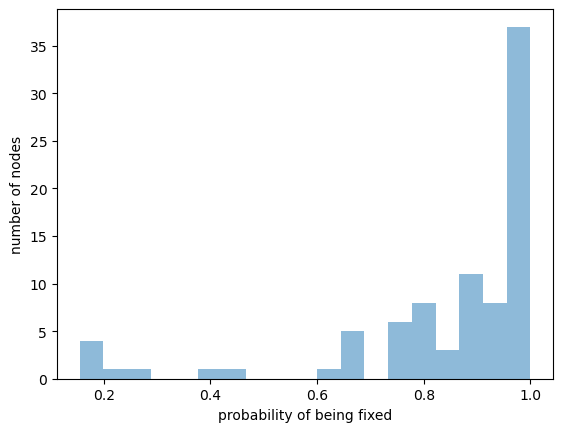

In [39]:


data = counts/len(unchanged)
print(np.mean(data))

bins = np.linspace(min(data), 
                   max(data),
                   20) # fixed number of bins

#plt.xlim([min(data)-0.1, max(data)+0.1])

plt.hist(data, bins=bins, alpha=0.5)
#plt.title('')
plt.xlabel('probability of being fixed')
plt.ylabel('number of nodes')

plt.show()

In [17]:
from collections import Counter
Counter(att_sizes)

Counter({'4': 86712,
         '20': 448,
         '12': 2512,
         '1': 57304,
         '2': 8160,
         '6': 1824,
         '3': 1620,
         '5': 3988,
         '7': 16,
         '10': 24})

In [1]:
import bns
import numpy as np
import networkx as nx
G_rs = nx.read_gml('reach_simp.gml')
G_rs2 = nx.read_gml('rs2.gml')
np.set_printoptions(threshold=20)
attrs,sz = bns.attractors_from_txt('atts_rs')
print(len(attrs))
attrs2,sz = bns.attractors_from_txt('atts_rs2')
print(len(attrs2))


295120
295120


In [25]:
mobile = sorted(G_rs2.nodes())
for i in range(87):
    for j in range(len(attrs2)):
        att_i = set(np.array(attrs2[j])[:,i])
        
        #if att_i == {0}:
            #static0.append(sorted(G_rs2.nodes())[i])
        #if att_i == {1}:
            #static1.append(sorted(G_rs2.nodes())[i])
        if att_i != {0,1}:
            mobile.remove(sorted(G_rs2.nodes())[i])
            break            
print(mobile)

['adiY', 'aidB', 'araC', 'arcA', 'argP', 'asnC', 'betI', 'bglJ', 'cadC', 'cra', 'crp', 'csgD', 'cspA', 'cusR', 'dcuR', 'dnaA', 'dpiA', 'evgA', 'exuR', 'fhlA', 'fis', 'flhC', 'flhD', 'fliZ', 'fnr', 'fucR', 'fur', 'gadE', 'gadW', 'gadX', 'galR', 'galS', 'glcC', 'glnG', 'gutM', 'hdfR', 'hns', 'hyfR', 'idnR', 'leuO', 'lldR', 'lrp', 'lsrR', 'malI', 'marA', 'marR', 'mazE', 'mazF', 'melR', 'metJ', 'metR', 'mlc', 'mlrA', 'mraZ', 'nac', 'narL', 'nhaR', 'nikR', 'ompR', 'oxyR', 'pdeL', 'pdhR', 'phoB', 'prpR', 'ptsG', 'purR', 'putA', 'puuR', 'rbsR', 'rcsA', 'rcsB', 'rhaR', 'rhaS', 'rob', 'soxR', 'soxS', 'srlR', 'stpA', 'tdcA', 'uxuR', 'xylR', 'ydeO', 'yeiL', 'yiaJ', 'yjjQ', 'yqjI', 'zraR']
['aidB', 'arcA', 'asnC', 'cadC', 'exuR', 'fnr', 'fur', 'galR', 'hyfR', 'leuO', 'lldR', 'lrp', 'metJ', 'metR', 'mlc', 'mraZ', 'narL', 'purR', 'rob', 'soxR', 'ydeO', 'yiaJ', 'yqjI']


In [34]:
print(len(mobile))
import csv
f = open('results_reach.csv','r',encoding='utf-8')
reader = csv.reader(f)
result = list(reader)
#print(scc1_expanded)

#print(G_rs1.nodes())
print(sorted(list(set(result[0][:39])&set(mobile))))
print(sorted(result[0][:39]))

23
['arcA', 'asnC', 'exuR', 'fnr', 'fur', 'galR', 'mlc', 'mraZ', 'rob', 'soxR', 'ydeO', 'yiaJ']
['arcA', 'argP', 'asnC', 'bglJ', 'cra', 'crp', 'cspA', 'exuR', 'fis', 'fnr', 'fur', 'gadW', 'gadX', 'galR', 'galS', 'glnG', 'hns', 'marA', 'marR', 'mazE', 'mazF', 'mlc', 'mraZ', 'nac', 'oxyR', 'pdhR', 'phoB', 'ptsG', 'rcsA', 'rcsB', 'rhaR', 'rhaS', 'rob', 'soxR', 'soxS', 'srlR', 'uxuR', 'ydeO', 'yiaJ']


In [11]:

core = reduced_atts(np.array(attrs2),G_rs2,set(G_rs2.nodes()))
core_in_rs = reduced_atts(np.array(attrs),G_rs,G_rs2.nodes())
print(core_in_rs ^ core)

{'uxuR', 'fis', 'pdeL', 'fucR', 'metJ', 'metR', 'prpR', 'csgD', 'narL', 'nac', 'rbsR', 'melR', 'gadX', 'soxR', 'exuR', 'mazF', 'gutM', 'dcuR', 'crp', 'mazE', 'cspA', 'bglJ', 'aidB', 'cadC', 'nikR', 'dnaA', 'putA', 'fhlA', 'pdhR', 'marR', 'rhaS', 'rcsB', 'srlR', 'flhD', 'yeiL', 'hns', 'zraR', 'flhC', 'mraZ', 'marA', 'soxS', 'galS', 'hdfR', 'asnC', 'yqjI', 'malI', 'lrp', 'glnG', 'purR', 'arcA', 'hyfR', 'nhaR', 'yjjQ', 'evgA', 'gadE', 'oxyR', 'fliZ', 'argP', 'mlc', 'lsrR', 'araC', 'leuO', 'gadW', 'betI', 'glcC', 'rhaR', 'cra', 'idnR', 'puuR', 'lldR', 'ydeO', 'ptsG', 'mlrA', 'galR', 'yiaJ', 'dpiA', 'tdcA', 'fur', 'rob', 'rcsA', 'stpA', 'adiY', 'ompR', 'fnr', 'cusR', 'xylR', 'phoB'}
['zraR', 'ptsG', 'gadX', 'rhaR', 'leuO', 'asnC', 'hdfR', 'galR', 'fhlA', 'dnaA', 'metR', 'cusR', 'mlc', 'hns', 'puuR', 'glnG', 'yiaJ', 'ompR', 'putA', 'cadC', 'dcuR', 'rhaS', 'stpA', 'pdhR', 'melR', 'fnr', 'evgA', 'crp', 'csgD', 'araC', 'adiY', 'yqjI', 'cspA', 'malI', 'srlR', 'gadE', 'idnR', 'mraZ', 'pdeL', 'pho

In [7]:
def get_element_index(ob_list, word_list):
    idx_list = []
    for word in word_list:
        idx = [i for (i, v) in enumerate(ob_list) if v == word]
        idx_list+=idx
    idx_list = np.array(idx_list)
    return idx_list

def get_corr_element(ob_list, idx_list):
    word_list = []
    for word in word_list:    
        word = [v for (i, v) in enumerate(ob_list) if i == idx]
        word_list+=word
    word_list = np.array(word_list)
    return word_list
def simplify(Graph):
    all_nodes = Graph.nodes
    simplified_nodes = []
    for node in all_nodes:
        in_degree = Graph.in_degree(node)
        out_degree = Graph.out_degree(node)
        if out_degree == 0:
            continue
        else:
            simplified_nodes.append(node)
    G_simplified = Graph.subgraph(simplified_nodes)
    print(len(simplified_nodes))
    return G_simplified, simplified_nodes
def reached_by(G,group):
    # input: nx.Graph G & group of nodes (list or set)
    # output: a list of nodes reaching to the given group starting with the original group
    nums_reached = []
    nodes_reached = []
    set_reached = set()
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    group = list(group)
    for j in range(len(group)):
        num_reached = N
        nodes_reaching_to_j = list(np.array(nodes))
        for k in range(N):
            try:
                length=nx.shortest_path_length(G,source=nodes[k],target=group[j])
            except nx.NetworkXNoPath:
                num_reached -= 1
                nodes_reaching_to_j.remove(nodes[k])
                
        nums_reached.append(num_reached)
        nodes_reached.append(nodes_reaching_to_j)
        set_reached = set_reached | set(nodes_reaching_to_j)
        
    set_reached = set_reached - (set_reached & set(group))
    set_reached = list(set_reached)
    list_reached = sorted(group + set_reached)
    print(len(set_reached))
    return list_reached
#def expanded_core(G,group):
def num_reachable(G,group):
    # input: nx.Graph G & group of nodes (list or set)
    # output: a list of nodes reaching to the given group starting with the original group
    nums_reached = []
    nodes_reached = []
    set_reached = set()
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    group = list(group)
    for j in range(len(group)):
        num_reached = N
        nodes_reaching_to_j = list(np.array(nodes))
        for k in range(N):
            try:
                length=nx.shortest_path_length(G,source=group[j],target=nodes[k])
            except nx.NetworkXNoPath:
                num_reached -= 1
                
                
        nums_reached.append(num_reached)
        
    return nums_reached    
def reduced_atts(atts,G,group):
    # input: attractor array of [num_atts,len_att,num_nodes], corresponding graph G, group of nodes (list or set)
    # output: a list of patterns (str)
    group_idx = get_element_index(sorted(list(G.nodes())), sorted(list(group)))
    print(group_idx)
    atts_group = atts[:,:,group_idx]
    atts_group_reduced = set()
    for n in range(atts_group.shape[0]):
        att = atts_group[n,:,:]
        att_set = set()
        for m in range(6):
            attm = att[m,:]
            #print(attm)
            attm = list(attm)
            attm = [str(i) for i in attm]
            attm = ''.join(attm)
            att_set.add(attm)
        att_set.add(str(len(att_set)))
        att_str = ','.join(sorted(list(att_set)))
        atts_group_reduced.add(att_str)
    return  atts_group_reduced
def unique_states(atts,group_idx):
    atts_scc0 = atts[:,:,group_idx]
    atts_scc0_reshape=np.reshape(atts_scc0,(6*atts_scc0.shape[0],len(group_idx)))
    states0 = []
    for n in range(atts_scc0_reshape.shape[0]):
        state = atts_scc0_reshape[n,cc]

        state = list(state)
        state = [str(i) for i in state]
        state = ''.join(state)

        if state not in states0:
            states0.append(state)
    return states0
def delete_unchanging(freq,G,group):
    group = list(group)
    idx = get_element_index(sorted(list(G.nodes())), sorted(group))
    freqs = list(freq[idx])
    changing = []
    for i in range(len(list(idx))):
        if freqs[i] == 0:
            continue
        else:
            changing.append(group[i])
    return changing

In [7]:
from utils import *
import networkx as nx
bns(nx.Graph(),'try1')

In [ ]:
diffs = []
diff_sets = []
for att in atts:
    diff = []
    diff_set = set()
    for i in range(len(att)-1):
        changed = abs(att[i+1]-att[i])
        #print(changed.shape)
        arr_changed = np.squeeze(np.argwhere(changed>0))
        set_changed = set(list(arr_changed))
        diff.append(arr_changed)
        diff_set = set.union(diff_set,set_changed)
    changed = abs(att[0]-att[len(att)-1])
    arr_changed = np.squeeze(np.argwhere(changed>0))
    set_changed = set(list(arr_changed))
    diff.append(arr_changed)
    diff_set = set.union(diff_set,set_changed)
    #print(len(diff_set))
    diffs.append(diff)
    diff_sets.append(diff_set)

In [8]:
from bns import *
atts,sz = attractors_from_txt('att_reach_simp')
arr_diffs = []
for att in atts:
    for i in range(len(att)-1):
        changed = abs(att[i+1]-att[i])     
        arr_diffs.append(changed)
    changed = abs(att[0]-att[len(att)-1])
    arr_diffs.append(changed)
arr_diffs = np.array(arr_diffs)
freq = np.sum(arr_diffs,axis=0)
np.save('att_reach_simp.npy',att)
np.save('arr_diffs.npy',arr_diffs)
np.save('freq.npy',freq)

In [9]:
import csv
freq = np.sum(arr_diffs,axis=0)
rsnodes = sorted(list(np.load('nodes_reach_simp.npy',allow_pickle=True)))

# 1. 创建文件对象
f = open('freq.csv','w',encoding='utf-8')
# 2. 基于文件对象构建 csv写入对象
csv_writer = csv.writer(f)
# 3. 构建列表头
csv_writer.writerow(np.arange(0,876,1))
csv_writer.writerow(rsnodes)
csv_writer.writerow(freq)
f.close()


In [4]:
freq_dict = {}
for x in list(freq) :
    freq_dict[x] = freq_dict.get(x, 0) + 1
    
x = list(freq_dict.keys())
y = list(freq_dict.values())

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x,y)
plt.show()

print(freq_dict[764010],freq_dict[763594],freq_dict[763178],freq_dict[762762])
print(freq_dict[0])
import pandas as pd
df_freq = pd.DataFrame(data=freq,index=nodes,columns=['frequency'])
df_freq.loc[nodes_rs2,:]

TypeError: 'numpy.float64' object is not iterable

In [ ]:
import networkx as nx
G_r = nx.read_gml('reach_simp.gml')
G_wcc = nx.read_gml('wcc.gml')
sccs = sorted(nx.strongly_connected_components(G_r),key=len, reverse=True)

print(sccs[0])
changed_every_time = ['mdh','tpx','rbsC','cas1','casD','mhpR','crr','mhpA','recF','fdhF','hypB','gltT','mazG','narG','narK','fau','gspC']
for node in changed_every_time:
    
    print(G_rs.out_degree(node))